# Make many stationary SPG outputs non-stationary

This notebook processes multiple runs of Leroy's stationary SPG.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from magicc import Magicc
from spg.stationary_converter import StationaryConverter

In [3]:
start_time = datetime.now()

In [4]:
#pathway = "rcp85"
#pathway = "ssp245"
pathways = [
    "rcp26","rcp45","rcp60","rcp85",
    "ssp119","ssp126","ssp245","ssp370","ssp434","ssp460","ssp585"
]

#location = "auckland"
#location = "tauranga"
location = "christchurch"
#location = "dunedin"

spg_runs = list(range(1,10+1))

## Load Weather@Home datasets

In [5]:
t_prime_sh_land = {
    "batch_870_ant": 1.728,
    "batch_871_ant": 2.277,
    "batch_872_ant": 3.384
}

In [6]:
def load_weather_at_home(data_path):
    files = sorted(data_path.glob("*.nc"))
    precipitations = []
    incomplete_datasets_count = 0
    for file in files:
        dataset = xr.open_dataset(file)
        if len(dataset['time1']) != 600:
            incomplete_datasets_count += 1
            continue
        # Extract the last year of data and get rid of the 'z0' axis
        dataset = dataset.isel(time1=slice(600-360, 600), z0=0)
        precipitation = dataset["precipitation"].values
        precipitations.append(precipitation)

    precipitations = np.concatenate(precipitations)
    
    # Convert units to mm/day
    precipitations = precipitations * 24*60*60

    processed_count = len(files) - incomplete_datasets_count
    print(f"Processed {processed_count:,} complete files (skipped {incomplete_datasets_count} incomplete datasets).")
    return precipitations

In [7]:
%%time
# Load all data
base_data_path = Path(f"/mnt/temp/projects/otago_uni_marsden/data_keep/weather_at_home/{location}/")
weather_at_home = {}
for sim_label in t_prime_sh_land.keys():
    print(f"Loading {sim_label}...")
    data_path = base_data_path / sim_label
    precipitation = load_weather_at_home(data_path)
    weather_at_home[sim_label] = precipitation
print("Finished loading")

Loading batch_870_ant...
Processed 2,543 complete files (skipped 113 incomplete datasets).
Loading batch_871_ant...
Processed 2,496 complete files (skipped 147 incomplete datasets).
Loading batch_872_ant...
Processed 2,549 complete files (skipped 131 incomplete datasets).
Finished loading
CPU times: user 30.4 s, sys: 1.05 s, total: 31.5 s
Wall time: 1min 46s


## Analyse Weather@Home

In [8]:
def generate_dataframe(quantile):
    sim_labels = weather_at_home.keys()
    temperatures = [t_prime_sh_land[key] for key in sim_labels]
    results_at_quantile = [np.quantile(weather_at_home[key], quantile) for key in sim_labels]

    df = pd.DataFrame({
        "temperature": temperatures,
        "precipitation": results_at_quantile
    })
    df = df.set_index("temperature")
    return df

In [9]:
def analyse_dataframe(df, threshold=0.1):
    if np.any(df["precipitation"] < threshold):
        return None
    
    def func(x, p_zero, rate):
        return p_zero * np.exp(rate*x)

    params, _ = curve_fit(
        func, 
        df.index.to_numpy(), 
        df["precipitation"].to_numpy(),
        p0=[0,0]
    )

    assert params[0] >= 0, "p_zero is negative"

    return {
        "f": func,
        "params": params
    }

In [10]:
def plot_one(df, fit, title):
    if fit is None:
        raise Exception("No fit information")
        
    ax = sns.scatterplot(
        x=df.index,
        y=df["precipitation"],
    )
    xs = np.linspace(
        np.min(df.index),
        np.max(df.index),
        num=1000
    )
    func = fit["f"]
    params = fit["params"]
    ys = func(xs, *params)
    sns.lineplot(
        x=xs,
        y=ys,
        hue=0,
        legend=False,
    )
    ax.set_ylabel("Precipitation (mm/day)")
    ax.set_xlabel("T' SH Land (deg C)")
    ax.set_title(title+f"\np_zero: {params[0]:.2f} mm/day, rate: {params[1]*100:.1f}% per K")
    
    return ax

In [11]:
def analyse_many(quantiles):
    # Loop through quantiles, produce combined dataframe
    p_zeros = []
    rates = []
    qs = []
    for q in quantiles:
        df = generate_dataframe(q)
        try:
            fit = analyse_dataframe(df)
        except:
            print(f"p_zero was negative for quantile {q}")
            continue
        if fit is None:
            continue
        params = fit["params"]
        qs.append(q)
        p_zeros.append(params[0])
        rates.append(params[1])
    result = pd.DataFrame({
        "quantile": qs,
        "p_zero": p_zeros,
        "rate": rates
    })
    return result

In [12]:
quantiles = np.linspace(0,1, num=1001)
df = analyse_many(quantiles)
df

,quantile,p_zero,rate
0,0.645,0.091321,0.051104
1,0.646,0.092323,0.051352
2,0.647,0.093290,0.051757
3,0.648,0.094334,0.051796
4,0.649,0.095478,0.051505
...,...,...,...
351,0.996,23.797241,0.054325
352,0.997,27.364209,0.053702
353,0.998,32.591881,0.056607
354,0.999,41.636752,0.062481


In [13]:
# Function to interpolate rate given quantile
interpolate_rate = interp1d(
    x=df["quantile"].to_numpy(), 
    y=df["rate"].to_numpy(),
    fill_value="extrapolate"
)

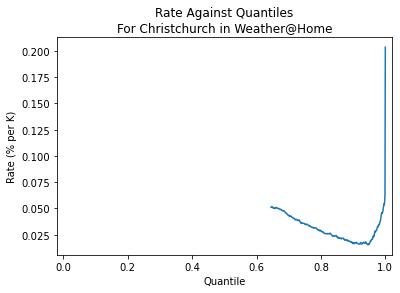

In [14]:
ax = sns.lineplot(
    x=df["quantile"],
    y=df["rate"]
)
ax.set_title(f"Rate Against Quantiles\nFor {location.title()} in Weather@Home")
x_margin=0.02
ax.set_xlim(0-x_margin,1+x_margin)
ax.set_ylabel("Rate (% per K)")
ax.set_xlabel("Quantile")
None # don't return a value

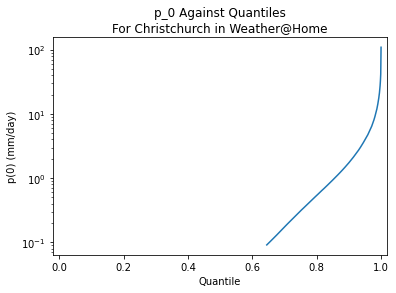

In [15]:
ax = sns.lineplot(
    x=df["quantile"],
    y=df["p_zero"]
)
ax.set_title(f"p_0 Against Quantiles\nFor {location.title()} in Weather@Home")
ax.set_yscale("log")
ax.set_xlim(0-x_margin,1+x_margin)
ax.set_ylabel("p(0) (mm/day)")
ax.set_xlabel("Quantile")
None # don't return a value

## MAGICC: Date to T'<sub>SH Land</sub>

Leroy created a CSV file with MAGICC data.  We create a function that, given a date, returns the (interpolated) T'<sub>SH Land</sub> for the specified pathway.

In [16]:
# Load MAGICC data
magicc = Magicc("../data/magic_tprime_sh_land.csv")
convert_date_to_t_tprime = {
    pathway: magicc.create_interpolator(pathway)
    for pathway in pathways
}

## Load observed data to obtain "average" t_prime used in training

In [17]:
# Load observed dataset
root_dir = Path("/mnt/temp/projects/otago_uni_marsden/data_keep/spg/station_data_hourly")
observations_path = root_dir / f"{location}.nc"
observation_ds = xr.open_dataset(observations_path)

# Training data was everything but the last 10,000 entries (see config/base_hourly.yml)
observation_ds = observation_ds.sel(time=observation_ds["time"][:-10000])

# Get t_prime values for all training dates
t_primes = {
    pathway: convert_date_to_t_tprime[pathway](observation_ds["time"])
    for pathway in pathways
}

# "Average" t_prime for the training data
t_prime_training = {
    pathway: np.mean(t_primes[pathway])
    for pathway in pathways
}
print(f"Average t_prime used in training: {t_prime_training}")

Average t_prime used in training: {'rcp26': 0.939395524093478, 'rcp45': 0.9388787813872889, 'rcp60': 0.9386635713249245, 'rcp85': 0.9413110536608492, 'ssp119': 0.9306775693664918, 'ssp126': 0.9306622305378504, 'ssp245': 0.9306436782336269, 'ssp370': 0.9304512129494918, 'ssp434': 0.9305710068765934, 'ssp460': 0.9305710094364225, 'ssp585': 0.9308119801092195}


In [18]:
end_time = datetime.now()
time_taken = end_time - start_time
print(f"It took {time_taken} to initialise")

It took 0:02:10.794938 to initialise


In [19]:
assert False

AssertionError: 

## Process each stationary SPG output

In [ ]:
location_to_folder = {
    "auckland": "auckland_epoch_010",
    "tauranga": "tauranga_epoch_003",
    "christchurch": "christchurch_epoch_008",
    "dunedin": "dunedin_epoch_009"
}

base_path = Path("/mnt/temp/projects/otago_uni_marsden/data_keep/spg/ensemble_hourly_paper/v10")

In [ ]:
def process_one_given_filenames(input_path, pathway, output_daily_path, output_hourly_path):
    stationary_converter = StationaryConverter()

    # Note that the pathway and dates are not important information from the perspective of the stationary SPG.
    stationary_converter.load_stationary_spg_output(input_path)
    stationary_converter.resample_to_daily()
    stationary_converter.calc_delta_t_prime(
        convert_date_to_t_tprime[pathway],
        t_prime_training[pathway]
    )
    stationary_converter.convert_precipitation_to_quantile()
    stationary_converter.calc_rate(interpolate_rate)
    stationary_converter.calc_multiplier()
    stationary_converter.calc_daily_non_stationary_precipitation()
    stationary_converter.calc_hourly_non_stationary_precipitation(
        convert_date_to_t_tprime[pathway]
    )

    stationary_converter.save_daily(output_daily_path)
    stationary_converter.save_hourly(output_hourly_path)

In [ ]:
def process_one(location, pathway, spg_run, output_dir=Path("./_output")):
    # Note that the pathway and dates are not important information from the perspective of the stationary SPG.
    input_path = base_path / location_to_folder[location] / f"{location}_{pathway}_{spg_run:03d}.nc"
    output_daily_path = output_dir / f"non_stationary_daily_{location}_{pathway}_{spg_run:03d}.nc"
    output_hourly_path = output_dir / f"non_stationary_hourly_{location}_{pathway}_{spg_run:03d}.nc"

    process_one_given_filenames(
        input_path=input_path,
        pathway=pathway,
        output_daily_path=output_daily_path,
        output_hourly_path=output_hourly_path
    )

In [ ]:
%%time
# Create output directory
output_dir = Path("_output")
output_dir.mkdir(exist_ok=True)

# for pathway in pathways:
#     for spg_run in spg_runs:
#         print(f"\nProcessing SPG for {location}, {pathway}, run {spg_run}")
#         process_one(location, pathway, spg_run, output_dir=output_dir)

process_one_given_filenames(
    input_path=base_path / location_to_folder[location] / f"{location}.nc",
    pathway="ssp245", # doesn't matter which pathway; they should all give the same result
    output_daily_path=Path(f"./_output/{location}-daily.nc"),
    output_hourly_path=Path(f"./_output/{location}-hourly.nc")
)
        
print("Finished.")